# Hamiltonian Simulation

Quantum Hamiltonian simulation is one of the most important problems in quantum computing. It consists in modeling the time evolution of a complex quantum system using more controllable devices, the quantum computers. Simulations of this type are essential to comprehend quantum systems that are described by a complex dynamics, such as molecules in chemistry or materials in condensed matter physics, where classical computers fail due the exponential scale up required by larger quantum systems.

In this guide, you will be using Classiq to work with simple problems of Hamiltonian simulation using two different methods:

* **Suzuki-Trotter decomposition**
* **qDRIFT**

Apart from these methods, known as product formulas, this guide also provide a brief discussion on other methods known as block-encoding methods, and links to a specific guide for this end.

# Table of contents

1. [Importance](#Importance)
2. [Suzuki-Trotter decomposition](#Suzuki-Trotter-decomposition)
    * [Exponentiation with depth constraint](#exponentiation-with-depth-constraint)
3. [qDRIFT](#qDRIFT)
4. [Hamiltonian simulation with block encoding](#Hamiltonian-simulation-with-block-encoding)
5. [Measuring the expected magnetization as a function of time](#measuring-the-expected-magnetization-as-a-function-of-time)
6. [Summary and Exercises](#summary-and-exercises)


# Importance

Quantum Hamiltonian simulation has several significant applications. Some of them are particularly interesting for physicists:

* Quantum Chemistry: It helps predict the properties of molecules using quantum methods such as the Quantum Variational Eigensolver (VQE), which can be more efficient than classical methods in certain conditions.
* Materials Science: It aids in designing new materials with desired properties by simulating their quantum mechanical behavior.
* Optimization and Machine Learning: Quantum simulations can solve complex optimization problems and improve machine learning algorithms.

Mathematically, we can approach the Hamiltonian Simulation problem as the following: Suppose we have a quantum computer that can run natively the evolution operators of the set of Hamiltonians $\{H_j\}$. Now, suppose we want to understand the dynamics of the following, more complex, Hamiltonian:

<details><summary>What are the operations that this quantum computer can effectively execute?</summary>

If this quantum computer can only execute the evolution operators of the set of Hamiltonians $\{H_j\}$, then we could have only operations in the form:

$$O = \prod_{j} e^{-i \,\tau_j H_j}.$$
</details>


\begin{equation}
H_{full} = \sum_{j} h_j H_j,
\end{equation}

For some real values $h_j$. Therefore, a decomposition of the operator into our set of operations is needed, formed by $\{e^{-itH_j}\}$, where $e^{-itH_j}$ is the evolution operator of the Hamiltonian $H$.

## Suzuki-Trotter decomposition

Now that the problem is stated, a possible solution is the Suzuki-Trotter decomposition, also known as Trotterization. Simply put, this method involves "breaking" the evolution operator into the evolution operators of its components. In the first order, it looks like this:

\begin{equation*}
e^{-itH}=\exp\left\{-it\sum_{j=1}^N h_j H_j\right\} \approx \left(\prod_{j}^N e^{-it, h_j, H_j/n}\right)^n + \mathcal{O}(t^2/n).
\end{equation*}

More details about this decomposition can be found in [[1]](#ts_paper).

This formula is very important and has applications in several scenarios. Additionally, if we need an error that scales better than $t^2$, it is possible to achieve higher-order Suzuki-Trotter formulas. For example, the second-order Suzuki-Trotter would look like this:

\begin{equation*}
    e^{-itH}=\exp\left\{-i\left(\sum_{j=1}^N \frac{t_j}{2}\,H_j + \sum_{j=N}^1 \frac{t_j}{2}\,H_j\right)\right\} \approx \left(\prod_{j=1}^N e^{-it_j\, H_j/(2n)}\prod_{j=N}^1 e^{-it_j\, H_j/(2n)}\right)^n + \mathcal{O}(t^3/n).
\end{equation*}

Higher orders for the Suzuki-Trotter formula can be found in [[1](#ts_paper)]. However, as the number of terms in the Hamiltonian and the approximation order increases, it gets more complicated to construct the Suzuki-Trotter formulas. To this end, one can use Classiq's function `suzuki_trotter()` to execute an operator's Trotter decomposition, specifying the order and number of repetitions. 

The following example demonstrates how to use it:

Now that the inputs for the Suzuki-Trotter method are defined, let's apply it to the simple example of approximating the dynamics of the following two-qubits Hamiltonian 


$$H = 0.3 \, Z\otimes Z + 0.7 \,X\otimes I + 0.2\, I\otimes X,$$

which represents two spins interacting in a transversal field. First, we need to identify the operators $\{H_j\}$ and its respective coefficients $\{h_j\}$:

$$
\begin{split}
    H_1 = Z \otimes Z,\text{ coefficient: }h_1 = 0.3; \\
    H_2 = X \otimes I,\text{ coefficient: }h_2 = 0.7; \\
    H_3 = I \otimes X,\text{ coefficient: }h_3 = 0.2. \\
\end{split}
$$

The second step is to define the number $n$ of repetitions into which we will "break" the evolution. In this case, we will apply it for $n=10$. The order of the Suzuki-Trotter decomposition can be altered in the parameter ``order``. In the current case, you will be applying it to the first order. 

Also, it is necessary to define the evolution coefficient $t$: This coefficient states how much time the quantum system will be evolving under this Hamiltonian, and it is set according to the specific application you want. The evolution coefficient is set in the `evolution_coefficient` variable, and in this simple example, we will consider it to be unitary. In [this part of the guide](#measuring-the-expected-magnetization-as-a-function-of-time), you can follow an example where the evolution coefficient varies.

In [1]:
from classiq import *

# Defining the Hamiltonian:
HAMILTONIAN = [
    PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=0.3),
    PauliTerm(pauli=[Pauli.X, Pauli.I], coefficient=0.7),
    PauliTerm(pauli=[Pauli.I, Pauli.X], coefficient=0.2),
]


@qfunc
def main(qba: Output[QArray[QBit]]):
    allocate(2, qba)
    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=1.0,
        order=1,
        repetitions=10,
        qbv=qba,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
write_qmod(qmod, "trotter")
show(qprog)

Opening: https://platform.classiq.io/circuit/65d9b690-73ef-49f5-bc67-4455679a99c6?version=0.45.1


## Exponentiation with depth constraint

It is also possible to generate an efficient decomposition of an evolution operator with Classiq's function `exponentiation_with_depth_constraint. Given the maximum depth of the decomposition and the inputs related to the Hamiltonian, the synthesizer finds the most accurate higher-order Trotter decomposition and applies it. 

Consider a maximum depth of $N=30$ for the previous example yields:

In [2]:
from classiq import *


@qfunc
def main(qba: Output[QArray[QBit]]):

    allocate(2, qba)
    exponentiation_with_depth_constraint(
        HAMILTONIAN,
        evolution_coefficient=1,
        max_depth=30,
        qbv=qba,
    )


qmod = create_model(main)
write_qmod(qmod, "exponentiation")
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/ef40ba08-8991-472c-9bda-7fc9a92a0a93?version=0.45.1


You can use the IDE to check which order of the Suzuki-Trotter decomposition is being used. In the current case, it applies the first-order decomposition, denoted in the IDE by the name ``single_trotter_suzuki_layer_xxxx``. In the case of higher orders, the output would identify which order is being used.

![Trotter_gif](https://docs.classiq.io/resources/Trotter_order.gif)

## qDRIFT

The quantum stochastic drift protocol (qDRIFT) [[2]](#qdrift_paper) is similar to the first-order Suzuki-Trotter decomposition; however, it relies on a stochastic distribution of the evolution operators. The algorithm operates by sampling unitaries from the set $\{e^{-itH_j}\}$ according to a probability distribution defined by the weights $\{h_j\}$, normalized by a factor $\lambda = \sum_j h_j$. 

In a more structured manner, the qDRIFT protocol functions as follows:

**Input**: A list of Hamiltonian terms $\{H_j\}$, a classical oracle function SAMPLE() that returns an value $j$ according to the probability distribution $p_j = h_j/\lambda$ and a target precision $\epsilon$.

**Output**: An ordered list of evolution operators from the set $\{e^{-itH_j}\}$, that approximate the unitary $e^{-it\,H}$, with bound error $\epsilon$.

* First, you need to define a normalization to transform $\{h_j\}$ into a probability distribution. For this, define $\sum_j h_j = \lambda$.
* Secondly, the program's depth is defined according to the required precision. For this, set $N = \lceil 2\lambda^2t^2/\epsilon \rceil$.
* Lastly, you generate the ordered list of $N$ evolution operators according to the probability distribution.

**The qDRIFT has been proved to be a good alternative for the Suzuki-Trotter decomposition when the number of terms in the Hamiltonian is not sparse**, i.e., the number of terms on the expansion $H = \sum_j h_j H_j$ is not small when compared to all possible terms in it. This interesting method can be applied using Classiq's function ``qdrift()``. 

Its inputs are:

* ``pauli_operator``: ``CArray[PauliTerm]``: A list of Pauli operators that should be representing the terms $H_j$ and its respective coefficients $h_j$;
* ``evolution_coefficient ``: ``CArray`` The value $t$ for the coefficient in the time evolution operator;
* ``num_qdrift``:``CInt``: The number $N$ of unitary operators in the list of gates given by the qdrift;
* ``qbv``:``QArray[QBit]``: The target qubits.

In the current example, we will fix $N=288$ which corresponds to an error $\epsilon = 0.01$ in the approximation.

In [3]:
from classiq import *


@qfunc
def main(qba: Output[QArray[QBit]]):

    allocate(2, qba)
    qdrift(
        HAMILTONIAN,
        evolution_coefficient=1,
        num_qdrift=288,
        qbv=qba,
    )


qmod = create_model(main)
write_qmod(qmod, "qdrift")
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/e1358fe0-c2a7-42ad-9477-b5a095fa4e36?version=0.45.1


# Hamiltonian simulation with block encoding

The methods presented in this guide are known as product formulas for Hamiltonian simulation. However, there are different methods of Hamiltonian simulation available apart from the product formulas. For example, there is also the necessity of obtaining the effects of applying a linear combination of unitaries (LCU) of the form $U_{LCU} = \sum_i \alpha_i U_i$ in quantum systems. This can be done by using the [LCU method](https://docs.classiq.io/latest/explore/tutorials/linear_combination_of_unitaries/linear_combination_of_unitaries/) or methods that apply different block encoding of the operators, having different properties which will be briefly discussed in this section.

## Qubitization

Qubitization [[3]](#qubitization_paper) is a method that enables the efficient simulation of quantum Hamiltonians. The key idea is to embed the Hamiltonian into a larger unitary operator, method known as block encoding, that is specifically simulated using a quantum walk operator. This allows for precise control over the evolution of quantum states and can significantly reduce the resources required for Hamiltonian simulation. For more details on how to implement the Qubitization method, visit our guide on [Hamiltonian simulation with block encoding](https://docs.classiq.io/latest/explore/tutorials/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding/?h=hamiltonian+simulation).

## QSVT

Quantum Singular Value Transformation (QSVT) [[4]](#qsvt_paper) is a general method that enables the transformation of the singular values of matrices encoded in quantum states. In Hamiltonian simulation, the objective is to use a sequence of quantum circuits to apply polynomial transformations to the singular values of a matrix, which are related to its eigenvalues. For more details on how to implement the Qubitization method, visit our guide on [Hamiltonian simulation with block encoding](https://docs.classiq.io/latest/explore/tutorials/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding/?h=hamiltonian+simulation).

# Measuring the expected magnetization as a function of time

Now, its time to see an application of these different methods and how they perform in comparison with the exact evolution. For this, we will see the evolution of the expected value of a specific operator and compare it to the exact solution. In this section, the same Hamiltonian considered in the examples will be considered:

$$H = 0.3 \cdot \, Z\otimes Z + 0.7 \cdot \,X\otimes I + 0.2 \cdot \, I\otimes X.$$

However, now the attention will be centered to analyze a quantity that varies with different values of time. For this, we consider the behavior of the magnetization of the system, $M = (\langle I\otimes Z \rangle + \langle Z \otimes I\rangle)/2$ [[5]](#magnetization_paper), as a function of time. 

This result can be evaluated exactly by exponentiating the Hamiltonian $H$ directly and then, it is possible to compare both results:

In [4]:
import numpy as np
from scipy.linalg import expm

time_list = np.linspace(0, 2, 100).tolist()

# Hamiltonian matrix:
pauli_I = np.array([[1, 0], [0, 1]], dtype=np.complex128)
pauli_X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
pauli_Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
pauli_Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# Magnetization operator:
magnetization_matrix = (np.kron(pauli_Z, pauli_I) + np.kron(pauli_I, pauli_Z)) / 2

Hamiltonian_matrix = (
    0.3 * np.kron(pauli_Z, pauli_Z)
    + 0.7 * np.kron(pauli_X, pauli_I)
    + 0.2 * np.kron(pauli_X, pauli_I)
)
initial_state = np.zeros(4)
initial_state[0] = 1.0


def expected_value(state, operator):
    state_H = np.conj(state.T)
    return state_H @ operator @ state


ideal_magnetization = []
for t in time_list:
    state = expm(-1j * t * Hamiltonian_matrix) @ initial_state
    ideal_magnetization.append(expected_value(state, magnetization_matrix))

To evaluate the expectation values of magnetization, it is possible to use the ``estimate`` function for the Suzuki-Trotter and qdrift methods:

In [5]:
from classiq import *
from classiq.execution import ExecutionSession

magnetization_hamiltonian = [
    PauliTerm(pauli=[Pauli.Z, Pauli.I], coefficient=0.5),
    PauliTerm(pauli=[Pauli.I, Pauli.Z], coefficient=0.5),
]


@qfunc
def main(t: CReal, qba: Output[QArray[QBit]]):
    allocate(2, qba)
    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=t,
        order=1,
        repetitions=30,
        qbv=qba,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
TS_execution = ExecutionSession(qprog)

magnetization_TS = []
for t_values in time_list:
    res = TS_execution.estimate(magnetization_hamiltonian, {"t": t_values}).value
    magnetization_TS.append(res)

In [6]:
magnetization_qdrift = []


@qfunc
def main(t: CReal, qba: Output[QArray[QBit]]):
    allocate(2, qba)
    qdrift(
        HAMILTONIAN,
        evolution_coefficient=t,
        num_qdrift=288,
        qbv=qba,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
qdrift_execution = ExecutionSession(qprog)
for t_values in time_list:
    res = qdrift_execution.estimate(magnetization_hamiltonian, {"t": t_values}).value
    magnetization_qdrift.append(res)

For the ``exponentiation_with_depth_constraint``, values of ``evolution_coefficient`` must be defined before synthesizing, since it is an important part of finding the most efficient decomposition. Therefore, a loop is necessary to execute the quantum program for different evolution coefficients and the populations of the final states can be used to evaluate the expected magnetization: 

In [7]:
from classiq import *

magnetization_ewdc = []

for t in time_list:

    @qfunc
    def main(qba: Output[QArray[QBit]]):
        allocate(2, qba)
        exponentiation_with_depth_constraint(
            HAMILTONIAN,
            evolution_coefficient=t,
            max_depth=30,
            qbv=qba,
        )

    qmod = create_model(main)
    qprog = synthesize(qmod)
    res = execute(qprog).result()
    if "11" in res[0].value.counts:
        magnetization = (res[0].value.counts["00"] - res[0].value.counts["11"]) / 2048
    else:
        magnetization = res[0].value.counts["00"] / 2048
    magnetization_ewdc.append(magnetization)

We can now make a plot comparing the magnetization values of the three different methods with the exact values:

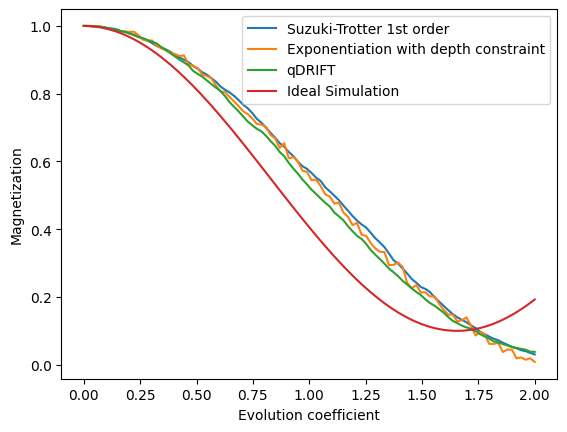

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel("Evolution coefficient")
ax.set_ylabel("Magnetization")
plt.plot(time_list, np.real(magnetization_TS), label="Suzuki-Trotter 1st order")
plt.plot(
    time_list, np.real(magnetization_ewdc), label="Exponentiation with depth constraint"
)
plt.plot(time_list, np.real(magnetization_qdrift), label="qDRIFT")
plt.plot(time_list, np.real(ideal_magnetization), label="Ideal Simulation")
plt.legend()
plt.show()

As expected, exponentiation with depth constraint and Suzuki-Trotter give similar results since they are basically different stances of the same method. The qDRIFT may return less precise results in this case, which is also expected since this method performs well for Hamiltonians with a dense, large number of terms. 

# Summary and Exercises

In this guide, the Suzuki-Trotter and qDRIFT methods for Hamiltonian simulation were introduced, highlighting the simplicity of Classiq's high level functional design in tackling complex problems.

To gather more familiarity with the methods presented here and see how the synthesis engine is able to optimize quantum models for Hamiltonian simulation, we suggest that you try to apply the methods learned here, such as the ``qDrift`` and ``Suzuki-Trotter``, as well as try different values of the ``evolution_coefficient`` to the following tutorial:

* [Hamiltonian Evolution for a Water Molecule](https://docs.classiq.io/latest/explore/tutorials/technology_demonstrations/Hamiltonian_evolution/Hamiltonian_evolution/)

It is encouraged to try and solving different molecules than the water molecule, with Classiq you can generate the Hamiltonian of any valid molecule structure.

# Read More

Besides the methods presented in this guide, there are also mixed approaches. One of them, proposed by Matthew Hagan and Nathan Wiebe [[6]](#quantum_sim_paper), offer an interesting combination of the Suzuki-Trotter and qDRIFT methods.

# References

<a id='ts_paper'>[1]</a>: [Finding Exponential Product Formulas of Higher Orders (Naomichi Hatano and Masuo Suzuki)](https://arxiv.org/abs/math-ph/0506007)

<a id='qdrift_paper'>[2]</a>: [A random compiler for fast Hamiltonian simulation (Earl Campbell)](https://arxiv.org/abs/1811.08017)

<a id='qubitization_paper'>[3]</a>: [Hamiltonian Simulation by Qubitization (Guang Hao Low and Isaac L. Chuang)](https://arxiv.org/abs/1610.06546)

<a id='qsvt_paper'>[4]</a>: [Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics (András Gilyén, Yuan Su, Guang Hao Low, and Nathan Wiebe)](https://arxiv.org/abs/1806.01838)

<a id='magnetization_paper'>[5]</a>: [The microscopic magnetization: concept and application (L. L. Hirst)](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.69.607)

<a id='quantum_sim_paper'>[6]</a>: [Composite Quantum Simulations (Matthew Hagan and Nathan Wiebe)](https://quantum-journal.org/papers/q-2023-11-14-1181/)